In [5]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 현재 경로 확인
!pwd

/content


In [7]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpt
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2

In [22]:
air = pd.read_csv('dataset/annotations/airplane.csv', header=None)
face = pd.read_csv('dataset/annotations/face.csv', header=None)
motorcycle = pd.read_csv('dataset/annotations/motorcycle.csv', header=None)

air.rename(columns={1:'x1',2:'y1',3:'x2',4:'y2',0:'filename',5:'target'}, inplace=True)
face.rename(columns={1:'x1',2:'y1',3:'x2',4:'y2',0:'filename',5:'target'}, inplace=True)
motorcycle.rename(columns={1:'x1',2:'y1',3:'x2',4:'y2',0:'filename',5:'target'}, inplace=True)

air.filename = air.filename.map(lambda x: 'dataset/images/airplane/'+x)
face.filename = face.filename.map(lambda x: 'dataset/images/face/'+x)
motorcycle.filename = motorcycle.filename.map(lambda x: 'dataset/images/motorcycle/'+x)

In [23]:
data=pd.concat([air,face,motorcycle], axis=0, ignore_index=True)

In [24]:
im = plt.imread('dataset/images/airplane/image_0001.jpg')

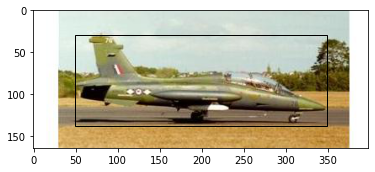

In [25]:
fig, ax = plt.subplots(1,1)
ax.imshow(im)
pt = mpt.Rectangle((49,30),349-49,137-30, fill=False) 
ax.add_patch(pt)

In [26]:
vgg = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3))
vgg.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
im = tf.keras.preprocessing.image.load_img('dataset/images/airplane/image_0001.jpg')

In [30]:
t = cv2.resize(np.array(im), (224,224))

In [31]:
t.shape

(224, 224, 3)

In [34]:
tt = vgg(t[tf.newaxis]).numpy()

In [36]:
tt.shape

(1, 7, 7, 512)

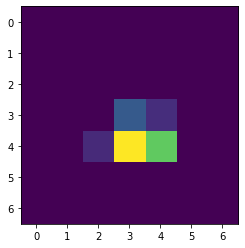

In [38]:
plt.imshow(tt[0,...,0]) # 비행기 이미지를 convolution layer를 통과 했을 때 / 512개 특징중 비행기 특징 중 하나  

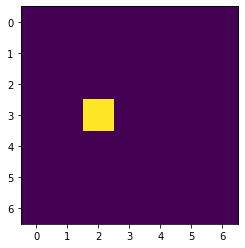

In [39]:
plt.imshow(tt[0,...,1])

# Yolo(You Only Look Once)

## YOLO Detection System

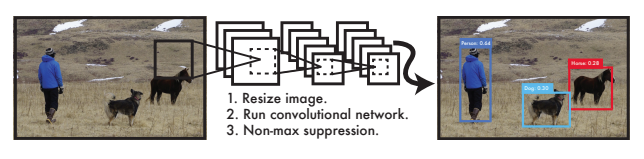

```python
1. ImageNet에서 사용했던 이미지 크기에서 두 배 키운 크기인 448x448 이미지로 크기를 변경한다 (Convolution 크기 mapping 하기 위해서)
2. Single convolutional neural network를 통과 시킨다 
3. Non-max suppression
```

## YOLO Architecture

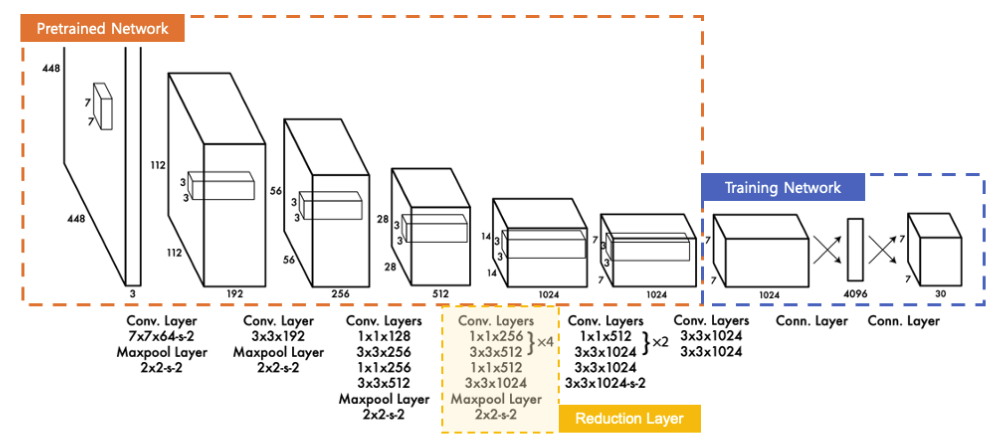

```python
1. Pretrained network 

- 주황색 테두리로 표현한 부분은 GoogLeNet을 이용하여 ImageNet 1000-class dataset을 사전에 학습한 결과를 Fine-Tuning한 네트워크이다 
- ImageNet의 데이터 셋은 224x224의 크기를 가진 이미지 데이터이지만, 이미지를 두 배 키워 448 x 448 x 3의 이미지를 입력 데이터로 받는다

2. Reduction layer 

- Reduction layer는 GoogLeNet의 기법을 응용 하여 연산량은 감소하면서 층은 깊게 쌓는 방식을 이용한다 

3. Training network 

- Pre-trained Network에서 학습한 feature를 이용하여 Class probability와 Bounding box를 학습하고 예측하는 네트워크 이다 
- YOLO의 예측 모델은 S x S x (B x 5 + C) 개의 파라미터를 결과로 출력하는데, PASCAL VOC 데이터 셋은 20개 클래스를 제공하기 때문에 C의 값은 20이고 B의 값이 2이라는 것은 하나의 그리드 셀에서 2개의 bounding box를 예측하겠다는 의미 이다. 그리고 그리드 셀은 7개로 정의 하였으므로 모두 계산하면 총 결과값은 1470이다 (7 x 7 x (2 X 5 + 20)
```

```

```

## NMS(Non Maximum Suppression)

> edge thinning 기법으로, 여러 box가 겹치게 되면 가장 확실한 것만 고르는 방법

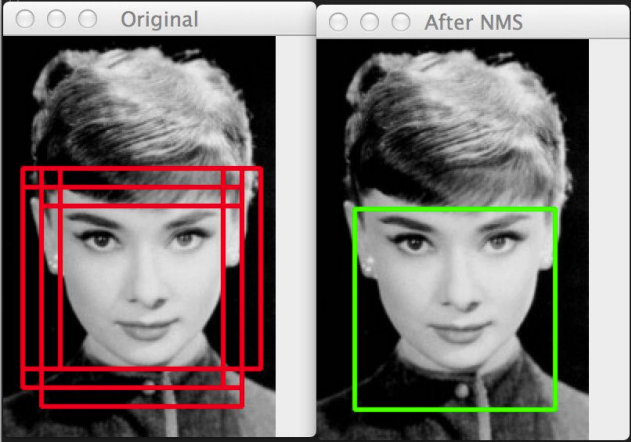

```python
1. Confidence(score)가 높은 순서대로 정렬한다
2. 제일 큰 Confidence값을 기준으로 하나씩 IOU를 비교 하여, 미리 설정해둔 threshold값보다 큰 경우 Bounding box를 버린다 
3. 그 다음 작은 Confidence값을 가진 Bounding box를 기준으로 다시 자신보다 작은 confidence를 가진 Bounding box와 IOU를 비교하여 Bounding box를 선택할지 버릴지 결정한다 
4. 3번 작업을 지속하여 최종적으로 남은 Bounding box를 사용한다 
```

In [40]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.patches as mpt

In [41]:
boxes = tf.constant([
    [190,380,(190+300),(380+150)],
    [300,420,(300+150),(420+210)],
    [320,360,(320+200),(360+200)],
    [390,50,(390+300),(50+300)],
    [390,50,(390+300),(50+300)],
], dtype=tf.float32)

In [42]:
scores = tf.constant([0.9,0.8,0.5,0.7,0.7])

In [44]:
tf.image.non_max_suppression(boxes, scores, 2)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1], dtype=int32)>

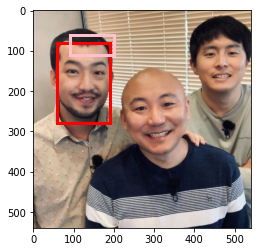

In [18]:
fig, ax = plt.subplots(1,1)
im = plt.imread('people.jpg')
plt.imshow(im)
m1 = mpt.Rectangle((60,80),130,200, edgecolor='red', facecolor='none', linewidth=3)
m2 = mpt.Rectangle((90,60),110,50, edgecolor='pink', facecolor='none', linewidth=3)
ax.add_patch(m1)
ax.add_patch(m2)

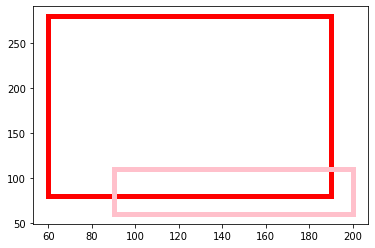

In [19]:
fig, ax = plt.subplots(1,1)
m1 = mpt.Rectangle((60,80),130,200, edgecolor='red', facecolor='none', linewidth=5)
m2 = mpt.Rectangle((90,60),110,50, edgecolor='pink', facecolor='none', linewidth=5)
ax.add_patch(m1)
ax.add_patch(m2)
plt.plot();

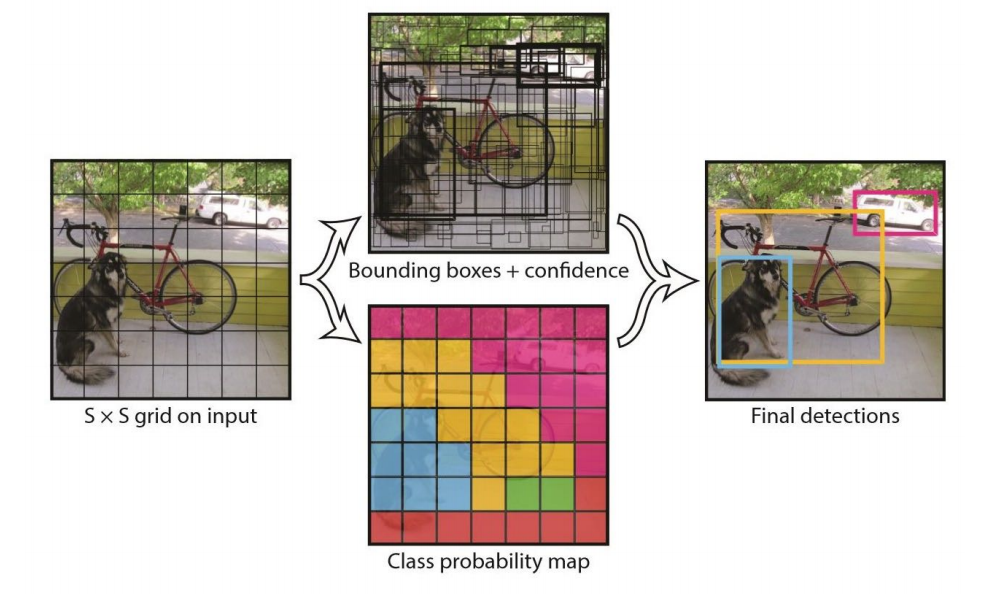

> NMS 처리 후 최소한의 Bounding box만 남긴다 

## Loss function 

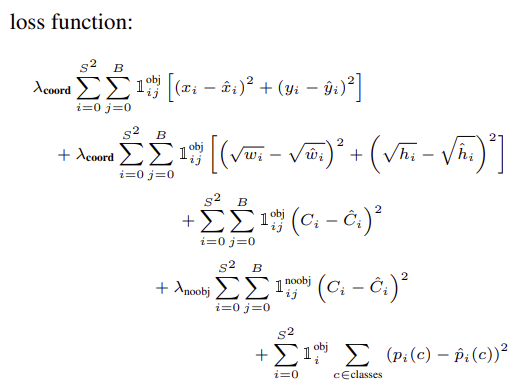

```python
- 1i^obj는 그리드 셀 i 안에 객체가 존재하는지 여부를 의미한다. 이 값은 객체 존재하면 1, 존재하지 않으면 0이다 
- 1ij^obj는 그리드 셀 i의 j번째 bounding box predictor가 사용되는지 여부를 의미한다. 
- Object가 존재하는 그리드 셀 i의 bounding box predictor j에 대해, x와 y의 loss를 계산한다
- Object가 존재하는 그리드 셀 i의 bounding box predictor j에 대해, w와 h의 loss를 계산한다. 큰 box에 대해서는 작은 분산(small deviation)을 반영하기 위해 제곱근을 취한 후, sum-squared error를 구한다. (같은 error라도 큰 box의 경우 상대적으로 IOU에 영향을 적게 준다)
- Object가 존재하는 그리드 셀 i의 bounding box predictor j에 대해, confidence score의 loss를 계산한다 (Ci = 1)
- Object가 존재하지 않는 그리드 셀 i의 bounding box predictor j에 대해, confidence score의 loss를 계산한다 (Ci = 0)
- Object가 존재하는 그리드 셀 i에 대해, conditional class probability의 loss를 계산한다. (pi(c)=1 if class c is correct, otherwise: pi(c)=0)

- λ_coord: coordinates(x, y, w, h)에 대한 loss와 다른 loss들과의 균형을 위한 balancing parameter
- λ_noobj: 객체가 있는 box와 없는 box 간에 균형을 위한 balancing parameter
```

## Learning techniques

```python
1. EarlyStopping
- 성능이 더 이상 높아지지 않으면 학습을 멈춘다 
2. LearningRateScheduler
- Epoch을 기준으로 learning rate를 조절한다 
3. ReduceROnPlateau
- 모델의 성능이 시간이 지남에 따라 향상되지 않으면 학습률을 낮춘다 
```

## 2-Stage-detector vs 1-Stage-detector

```

```

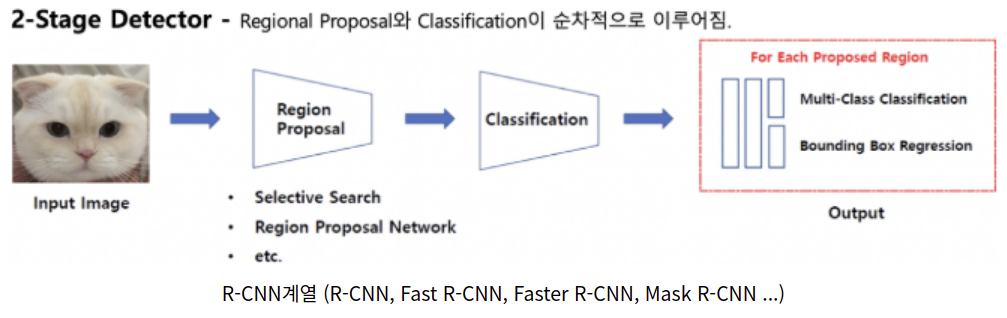

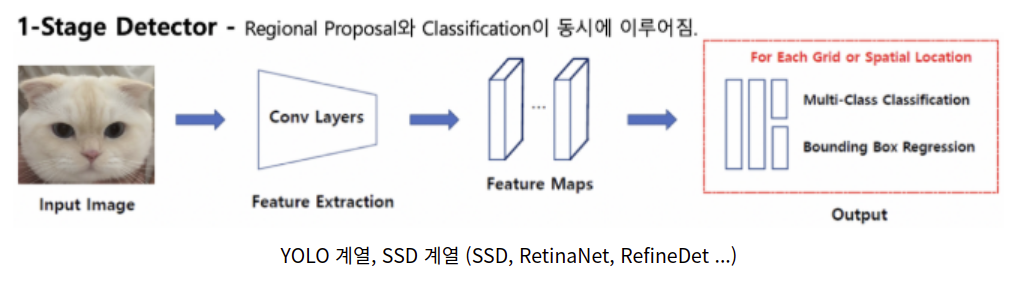

> 1-stage detector는 비교적 빠르지만 정확도가 낮고 <br>
> 2-stage detector는 비교적 느리지만 정확도가 높다